In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr
import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from math import sqrt

In [2]:
def create_df(site,target_variable):
    df = pd.read_csv('./' + site + '_combined.csv',header=0,index_col=0)

    df.index = pd.DatetimeIndex(df.index,freq='h')

    df[['NO2','temp','ws','wd','Volume','day','month','hour']] =  df[['NO2','temp','ws','wd','Volume','day','month','hour']].astype('int64')

    df = df.reset_index().rename(columns={'index':'ds',target_variable:'y'})
    
    return df 

In [3]:
def train_test_split(data,lockdown=True):
    if lockdown:
        train_start , train_end = '2017-01-01' , '2020-03-23'
        test_start, test_end = '2020-03-23' , '2020-04-22'
        
        train = data[(data.ds >= train_start ) & (data.ds < train_end ) ]
        test = data[(data.ds >= test_start ) & (data.ds <= test_end ) ]
    else:
        train_start , train_end = '2017-01-01' , '2020-01-23'
        test_start, test_end = '2020-01-23' , '2020-02-22'
        
        train = data[(data.ds >= train_start ) & (data.ds < train_end ) ]
        test = data[(data.ds >= test_start ) & (data.ds <= test_end ) ]
        
    return train, test

In [4]:
def Met_Vol_model(site, y, LD):
    df = create_df(site , y)
    df[['y']] = np.log(df[['y']])
    df = df.replace([np.inf, -np.inf], np.nan )
    train, test = train_test_split(df,lockdown=LD)
    model = Prophet()
    model.add_regressor('Volume')
    model.add_regressor('temp')
    model.add_regressor('ws')
    model.add_regressor('wd_1')
    model.add_regressor('wd_2')
    model.add_regressor('wd_3')
    model.add_regressor('wd_4')
    model.fit(train)
    forecast = model.predict(test)
    forecast[['yhat']] = np.exp(forecast[['yhat']])
    test[['y']] = np.exp(test[['y']])
    return model, train, test, forecast

In [5]:
def plot_FPM(forecast,test,colour,variables):
    plt.plot(forecast['ds'],test['y'],color='r',label='Observed')
    plt.plot(forecast['ds'],forecast['yhat'],color=colour,label=variables)
    plt.xticks(rotation=45)
    measured = test['y'].fillna(test['y'].mean())
    predicted = forecast['yhat'].fillna(forecast['yhat'].mean())
    RMSE = np.round(mean_squared_error(measured,predicted,squared=False),3)
    MAPE = np.round(mean_absolute_percentage_error(measured,predicted),3)
    corr, pval = np.round ( pearsonr(measured,predicted), 3) 
    #R2 = np.round(r2_score(measured,predicted),3)
    plt.title (f'RMSE:{RMSE}, MAPE:{MAPE}, corr:{corr}(p={pval})')
    plt.legend()
    plt.ylabel('NO2')

In [6]:
def scale(dataset,col_name, output_array=False):
    """Standard Z score scaler"""
    array = dataset[col_name].to_numpy()
    mean = np.mean(array)
    std = np.std(array)
    scaled = (array-mean)/std
    if output_array:
        return scaled
    else:
        return scaled, mean, std 

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, variable_num = 0,  dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names+=[('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[variable_num].shift(-i))
        if i == 0:
            names.append('var1(t)')
        else:
            names.append('var%d(t+%d)' % (1, i))
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg, names

In [8]:
def split_by_date( dataset , reframed_data, n_hours, date, days_prior=60):
    
    """ Split reframed data by specific date, days refers to the number 
    of days after the specified date the test set will contain.
    days prior refers to the number of days used to train the model """
    
    #get values from reframed data
    values = reframed_data.values
    
    #convert string into datetime
    date = pd.to_datetime(date)
    
    #create new dataframe
    df = dataset.reset_index().rename(columns = {'index':'date'})
    
    #ensure dates are in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    #find index for date
    date1_index = df.index[df['date'] == date ][0]
    
    #set train values to be all data upto given date 
    train = values[ date1_index - n_hours - (24*days_prior) : date1_index - n_hours, :]
    
    #get index of second date is 1 month into future
    date2_index = date1_index + (30 * 24)

    #test set two months after specified date
    test = values[ ( date1_index - n_hours ) : (date2_index - n_hours)  + 1 , :]
    
    #get specific dates for test period
    dates = df.date.to_numpy()
    specific_dates = dates[ date1_index  : date2_index+1  ]
    
    return train , test, specific_dates 

In [9]:
def reshape_LSTM(data, n_features, n_hours, hours_after):
    """ Reshape puts data in apprpriate format for LSTM usage
    [samples, timesteps, features] """
    n_obs = n_hours * n_features

    #split according to lag columns and output
    data_X, data_y = data[:, :n_obs], data[:, -hours_after:]
         
    # reshape input to be 3D [samples, timesteps, features]
    data_X_r = data_X.reshape((data_X.shape[0], n_hours , n_features))

    return data_X, data_y , data_X_r 

In [10]:
def inverse_scale(array,mean,std):
    """ Inversion of Standard scaler """
    inverse = (array*std) + mean 
    return inverse

In [11]:
def LSTM_model(cells,dropout,n_hours):
    # design network
    model = Sequential()
    model.add(LSTM(cells, activation = 'relu', dropout=dropout, input_shape=(train_X_r.shape[1], train_X_r.shape[2])))
    model.add(Dense(n_hours, activation = 'relu'))
    model.add(Dense(n_hours_out))
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

In [12]:
def data_prep_LSTM(site, period, variables):

        dataset = pd.read_csv('./'+ site + '_combined.csv', header=0, index_col=0)

        dataset.index = pd.DatetimeIndex(dataset.index,freq='h')

        #get all dates
        all_dates = pd.to_datetime(dataset.index.to_numpy())

        #scale continuous variables --> ['temp', 'ws', 'wd', 'Volume']
        continuous_vars = ['temp', 'ws', 'wd', 'Volume']
        for i in continuous_vars:
            dataset[i] = scale(dataset,i,output_array=True)

        # scale NO2 keep mean and std for inverse scaling
        no2, mean, std, = scale(dataset,'NO2',output_array=False)
        dataset['NO2'] = no2
        
        # chose specific variables
        dataset_copy = dataset[variables]

        hours_before = 24
        hours_after = 1

        days_before = 1
        days_after = 1

        # # specify the number of lag hours
        n_hours = hours_before * days_before # lag hours for each feature (t-x)
        n_features = len(variables) # number of features 
        n_hours_out = hours_after * days_after # lenghth of output forecast (<1 == <t+1)


        #convert values
        values = dataset_copy.values.astype('float32') 

        # frame as supervised learning
        reframed, names = series_to_supervised(values, n_hours, n_hours_out )


        train , test,  dates = split_by_date(dataset_copy, reframed, n_hours, period, 365)

#                             print(train.shape, test.shape, dates.shape)

        train_X, train_y , train_X_r = reshape_LSTM(train,n_features,n_hours,hours_after)
        test_X, test_y , test_X_r = reshape_LSTM(test,n_features,n_hours, hours_after)
        
        return train_X_r, train_y, test_X_r, test_y, n_hours, n_hours_out, dates, mean , std

In [13]:
def evaluate_model_LSTM(train_X_r, train_y, test_X_r, test_y,n_hours, n_hours_out, dates, mean , std):
    model = LSTM_model(24,0, n_hours)

    # fit network
    history = model.fit(train_X_r, train_y, epochs=100, batch_size=128, validation_split = 0.2 , verbose=0, shuffle=False)

    # get scaled prediction and observed values to calculate RMSE
    predicted = model.predict(test_X_r)[::n_hours_out]
    observed = test_y[::n_hours_out]

    # rescale for plotting
    predicted_rescaled = inverse_scale(predicted.flatten(), mean, std)[:dates.shape[0]]
    observed_rescaled = inverse_scale(observed.flatten(), mean, std)[:dates.shape[0]]

    
    return observed_rescaled, predicted_rescaled
    #plot 


In [14]:
def reshape_CNN_LSTM(data,n_hours, n_seq, n_steps, n_features):
    """ Reshape puts data in apprpriate format for LSTM_CNN usage
    [samples, n_seqs, timesteps, features] """
    n_obs = n_hours * n_features

    #split according to lag columns and output
    data_X, data_y = data[:, :n_obs], data[:, n_obs:]
         
    # reshape input to be 3D [samples, timesteps, features]
    data_X_r = data_X.reshape((data_X.shape[0], n_seq , n_steps, n_features))

    return data_X, data_y , data_X_r 

In [15]:
def CNN_LSTM_model(cells, filter_no, filter_size, dropout, n_hours, n_steps, n_features):
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters = filter_no, padding='same', kernel_size=filter_size, activation='relu'), input_shape=(None, n_steps, n_features)))

    filter_no = int ( filter_no / 2 )
    filter_size += 2
    dropout += 0.1
    model.add(TimeDistributed(Conv1D(filters = filter_no, padding='same', kernel_size=filter_size, activation='relu'), input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(Conv1D(filters = filter_no, padding='same', kernel_size=filter_size, activation='relu'), input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Dropout(dropout)))

    filter_no = int ( filter_no / 2 )
    filter_size += 2
    dropout += 0.1
    model.add(TimeDistributed(Conv1D(filters = filter_no, padding='same', kernel_size=filter_size, activation='relu'), input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(Conv1D(filters = filter_no, padding='same', kernel_size=filter_size, activation='relu'), input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    model.add(TimeDistributed(Dropout(dropout)))
    
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(cells, activation = 'relu',input_shape=(train_X_r.shape[1], train_X_r.shape[2])))
    model.add(Dense(n_hours, activation = 'relu'))
    model.add(Dense(n_hours_out))
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [16]:
def data_prep_CNN_LSTM(site, period, variables ):

        dataset = pd.read_csv('./'+ site + '_combined.csv', header=0, index_col=0)

        dataset.index = pd.DatetimeIndex(dataset.index,freq='h')

        #get all dates
        all_dates = pd.to_datetime(dataset.index.to_numpy())

        #scale continuous variables --> ['temp', 'ws', 'wd', 'Volume']
        continuous_vars = ['temp', 'ws', 'wd', 'Volume']
        for i in continuous_vars:
            dataset[i] = scale(dataset,i,output_array=True)

        # scale NO2 keep mean and std for inverse scaling
        no2, mean, std, = scale(dataset,'NO2',output_array=False)
        dataset['NO2'] = no2
        
        # chose specific variables
        dataset_copy = dataset[variables]

        hours_before = 24
        hours_after = 1

        days_before = 1
        days_after = 1

        # # specify the number of lag hours
        n_hours = hours_before * days_before # lag hours for each feature (t-x)
        n_features = len(variables) # number of features 
        n_hours_out = hours_after * days_after # lenghth of output forecast (<1 == <t+1)

        #date1 = period

        #convert values
        values = dataset_copy.values.astype('float32') 

        # frame as supervised learning
        reframed, names = series_to_supervised(values, n_hours, n_hours_out )


        train , test,  dates  = split_by_date(dataset_copy, reframed, n_hours, period, 365)

        n_seq = 3
        n_steps = int( n_hours / n_seq )

        train_X, train_y, train_X_r = reshape_CNN_LSTM(train, n_hours, n_seq, n_steps, n_features)
        test_X, test_y, test_X_r = reshape_CNN_LSTM(test, n_hours, n_seq, n_steps, n_features)
        
        return train_X_r, train_y, test_X_r, test_y, n_hours ,n_steps, n_hours_out,n_features, dates, mean , std




In [17]:
def evaluate_model_CNN_LSTM(train_X_r, train_y, test_X_r, test_y,n_hours,n_steps, n_hours_out, n_features,  dates, mean , std):
    
    model = CNN_LSTM_model(24, 32, 3, 0, n_hours,n_steps,n_features)

    # fit network
    history = model.fit(train_X_r, train_y, epochs=100, batch_size=128, validation_split = 0.2 , verbose=0, shuffle=False)

    # get scaled prediction and observed values to calculate RMSE
    predicted = model.predict(test_X_r)[::n_hours_out]
    observed = test_y[::n_hours_out]

    # rescale for plotting
    predicted_rescaled = inverse_scale(predicted.flatten(), mean, std)[:dates.shape[0]]
    observed_rescaled = inverse_scale(observed.flatten(), mean, std)[:dates.shape[0]]

    
    return observed_rescaled, predicted_rescaled


In [18]:
def plot_trace (observed_rescaled, predicted_rescaled, plot_days,colour, var_label):
    plt.plot(dates[:24*plot_days],observed_rescaled[:24*plot_days],color = 'r',label='Observed')
    plt.plot(dates[:24*plot_days],predicted_rescaled[:24*plot_days],color = colour,label=var_label)
    plt.xticks(rotation=45)
    MAPE = np.round ( mean_absolute_percentage_error(observed_rescaled,predicted_rescaled), 3)
    corr, p = np.round ( pearsonr(observed_rescaled,predicted_rescaled), 3) 
    RMSE = np.round ( mean_squared_error(observed_rescaled, predicted_rescaled,squared = False), 3 )
    plt.title (f'RMSE:{RMSE}, MAPE:{MAPE}, corr:{corr}(p={p})')
    plt.legend()
    plt.ylabel('NO2')

In [19]:
train_X_r, train_y, test_X_r, test_y, n_hours,n_steps,n_hours_out,n_features, dates, mean , std  = data_prep_CNN_LSTM('sharston','2020-03-23',['NO2'])
CNN_observed_shar_LD, CNN_predicted_shar_LD = evaluate_model_CNN_LSTM(train_X_r, train_y, test_X_r, test_y,n_hours,n_steps, n_hours_out,n_features, dates, mean , std)

train_X_r, train_y, test_X_r, test_y, n_hours, n_hours_out, dates, mean , std = data_prep_LSTM('sharston','2020-03-23',['NO2'])
LSTM_observed_shar_LD, LSTM_predicted_shar_LD = evaluate_model_LSTM(train_X_r, train_y, test_X_r, test_y,n_hours, n_hours_out, dates, mean , std)

metvolsmodel_ld, metvolstrain_ld, metvolstest_ld, metvolsforecast_ld = Met_Vol_model('sharston','NO2',True)

/Users/eliacharles/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [20]:
train_X_r, train_y, test_X_r, test_y, n_hours,n_steps,n_hours_out,n_features, dates, mean , std  = data_prep_CNN_LSTM('MCC','2020-03-23',['NO2'])
CNN_observed_pic_LD, CNN_predicted_pic_LD = evaluate_model_CNN_LSTM(train_X_r, train_y, test_X_r, test_y,n_hours,n_steps, n_hours_out,n_features, dates, mean , std)

train_X_r, train_y, test_X_r, test_y, n_hours, n_hours_out, dates, mean , std = data_prep_LSTM('MCC','2020-03-23',['NO2'])
LSTM_observed_pic_LD, LSTM_predicted_pic_LD = evaluate_model_LSTM(train_X_r, train_y, test_X_r, test_y,n_hours, n_hours_out, dates, mean , std)

metvolpmodel_ld, metvolptrain_ld, metvolptest_ld, metvolpforecast_ld = Met_Vol_model('MCC','NO2',True)

/Users/eliacharles/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [21]:
picadilly_comparison = pd.DataFrame({
              'Observed':CNN_observed_pic_LD,
             'CNN-LSTM': CNN_predicted_pic_LD,
             'LSTM': LSTM_predicted_pic_LD,
             'Prophet (Met+Vol)': metvolpforecast_ld['yhat'].to_numpy()}, index= dates)

picadilly_comparison['Hour'] = picadilly_comparison.index.hour

picadilly_comparison = pd.melt(picadilly_comparison.reset_index(drop=True), id_vars = ['Hour'], var_name = 'Model', value_name='NO2')

In [22]:
sharston_comparison = pd.DataFrame({
              'Observed':CNN_observed_shar_LD,
             'CNN-LSTM': CNN_predicted_shar_LD,
             'LSTM': LSTM_predicted_shar_LD,
             'Prophet (Met+Vol)': metvolsforecast_ld['yhat'].to_numpy()}, index= dates)

sharston_comparison['Hour'] = sharston_comparison.index.hour

sharston_comparison = pd.melt(sharston_comparison.reset_index(drop=True), id_vars = ['Hour'], var_name = 'Model', value_name='NO2')

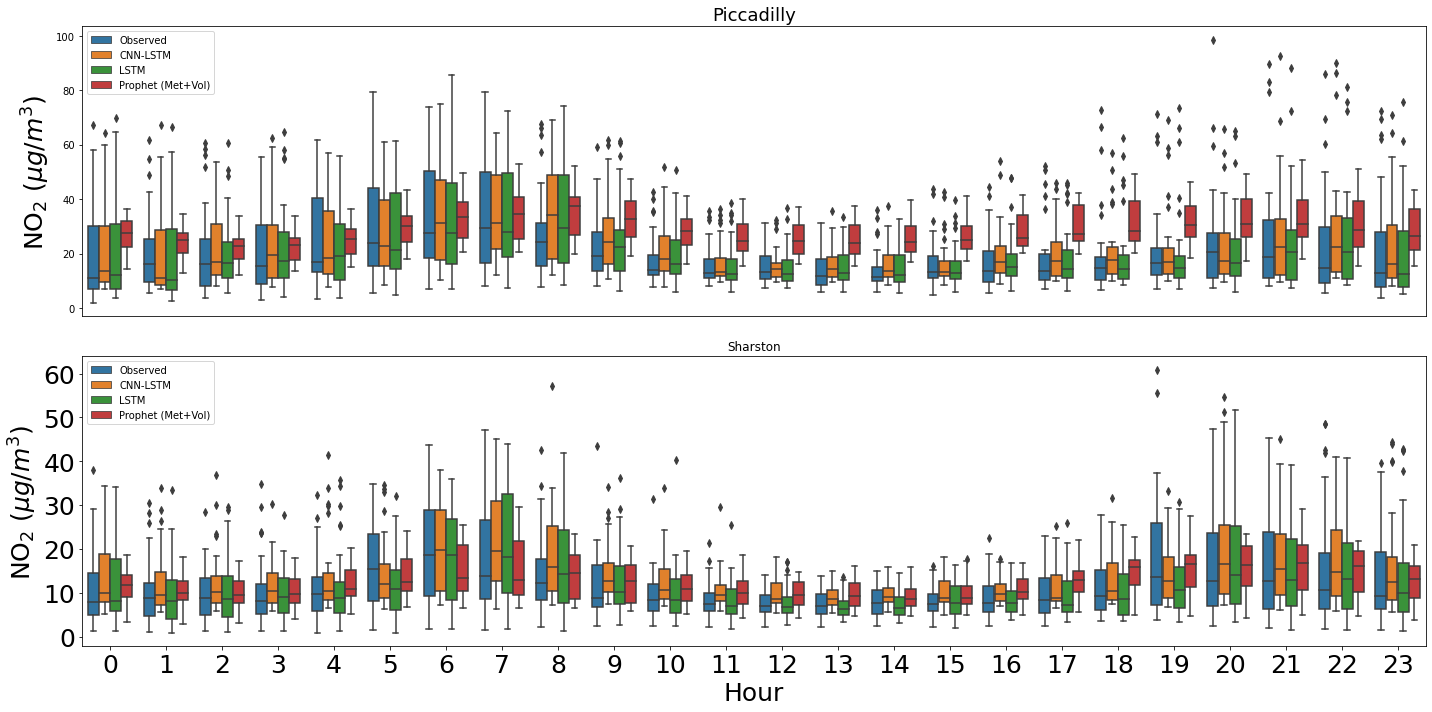

In [30]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
sns.boxplot(data=picadilly_comparison, x='Hour',y='NO2',hue='Model')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)',fontsize=25)
plt.legend()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.title('Piccadilly',fontsize=18)
plt.xlabel ( ' ' )
plt.subplot(2,1,2)
sns.boxplot(data=sharston_comparison, x='Hour',y='NO2',hue='Model')
plt.ylabel('NO${_2}$ (${\mu g/m^{3}}$)',fontsize=25)
plt.legend()
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.xlabel('Hour',fontsize=25)
plt.title('Sharston')
plt.tight_layout()
plt.savefig('./FiguresLSTM/ProphetvsANN.png')